In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import sys
import os
import json
import transformers
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
f = open ('/content/drive/MyDrive/MS/SMM/EXIST2023_training.json', "r")
  
# Reading from file
data = json.loads(f.read())

In [ ]:
df = pd.DataFrame(data).T.drop(['number_annotators','annotators','split'],axis=1)
df.columns = ['id','lang','tweet','sex','age','t1_lb','t2_lb','t3_lb']
df_en = df[df['lang']=='en']
df_es = df[df['lang']=='es']

In [ ]:
df_en.head()

,id,lang,tweet,sex,age,t1_lb,t2_lb,t3_lb
200001,200001,en,FFS! How about laying the blame on the bastard...,"[F, F, M, M, M, F]","[18-22, 23-45, 18-22, 23-45, 46+, 46+]","[YES, YES, NO, NO, YES, NO]","[JUDGEMENTAL, JUDGEMENTAL, -, -, REPORTED, -]","[[MISOGYNY-NON-SEXUAL-VIOLENCE], [SEXUAL-VIOLE..."
200002,200002,en,Writing a uni essay in my local pub with a cof...,"[F, F, M, M, M, F]","[18-22, 23-45, 18-22, 23-45, 46+, 46+]","[YES, YES, YES, NO, YES, YES]","[REPORTED, DIRECT, REPORTED, -, REPORTED, REPO...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION, MIS..."
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,"[F, F, M, M, M, F]","[18-22, 23-45, 18-22, 23-45, 46+, 46+]","[YES, YES, NO, YES, NO, YES]","[REPORTED, REPORTED, -, REPORTED, -, JUDGEMENTAL]","[[OBJECTIFICATION, SEXUAL-VIOLENCE], [STEREOTY..."
200004,200004,en,@GMB this is unacceptable. Use her title as yo...,"[F, F, M, M, M, F]","[18-22, 23-45, 18-22, 23-45, 46+, 46+]","[YES, YES, NO, YES, NO, NO]","[REPORTED, JUDGEMENTAL, -, JUDGEMENTAL, -, -]","[[MISOGYNY-NON-SEXUAL-VIOLENCE], [STEREOTYPING..."
200005,200005,en,‘Making yourself a harder target’ basically bo...,"[F, F, M, M, M, F]","[18-22, 23-45, 18-22, 23-45, 46+, 46+]","[YES, YES, NO, NO, NO, YES]","[JUDGEMENTAL, DIRECT, -, -, -, DIRECT]","[[SEXUAL-VIOLENCE, MISOGYNY-NON-SEXUAL-VIOLENC..."


In [ ]:
row_count = len(df_es)
print("Number of rows in the data:", row_count)

Number of rows in the data: 3660


In [ ]:
num_columns = df_en.shape[1]
print("Number of columns:", num_columns)

Number of columns: 8


In [ ]:
training_set_en = df_en.explode(['sex','age','t1_lb','t2_lb','t3_lb']).reset_index(drop=True)
training_set_es = df_es.explode(['sex','age','t1_lb','t2_lb','t3_lb']).reset_index(drop=True)

In [ ]:
f = open ('/content/drive/MyDrive/MS/SMM/EXIST2023_dev.json', "r")
  
# Reading from file
data = json.loads(f.read())

In [ ]:
df_val = pd.DataFrame(data).T.drop(['number_annotators','annotators','split'],axis=1)
df_val.columns = ['id','lang','tweet','sex','age','t1_lb','t2_lb','t3_lb']
df_val_en = df_val[df_val['lang']=='en']
df_val_es = df_val[df_val['lang']=='es']

In [ ]:
row_count = len(df_val_es)
print("Number of rows in the data:", row_count)

Number of rows in the data: 549


In [ ]:
val_set_en = df_val_en.explode(['sex','age','t1_lb','t2_lb','t3_lb']).reset_index(drop=True)
val_set_es = df_val_es.explode(['sex','age','t1_lb','t2_lb','t3_lb']).reset_index(drop=True)

In [ ]:
# check if we have cuda installed
if torch.cuda.is_available():
    # to use GPU
    device = torch.device("cuda")
    print('Using GPU')
else:
    device = torch.device("cpu")

Using GPU


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-large')

C:\Users\Sushant\anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Sushant\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
features_en = list(training_set_en['tweet'])
targets_en = list(training_set_en['t1_lb'])
val_features_en = list(val_set_en['tweet'])
val_targets_en = list(val_set_en['t1_lb'])

features_es = list(training_set_es['tweet'])
targets_es = list(training_set_es['t1_lb'])
val_features_es = list(val_set_es['tweet'])
val_targets_es = list(val_set_es['t1_lb'])

In [ ]:
MAX_LEN = 128
tokenized_feature_en = tokenizer(
                            # Sentences to encode
                            features_en, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN, 
                            # Return attention mask
                            return_attention_mask = True,   
                   )

MAX_LEN = 128
tokenized_feature_es = tokenizer(
                            # Sentences to encode
                            features_es, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN, 
                            # Return attention mask
                            return_attention_mask = True,   
                   )

In [ ]:

val_tokenized_feature_en = tokenizer(
                            # Sentences to encode
                            val_features_en, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            truncation=True,
                               
                   )


val_tokenized_feature_es = tokenizer(
                            # Sentences to encode
                            val_features_es, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            truncation=True,
                               
                   )

In [ ]:
le = LabelEncoder()
target_num_en = le.fit_transform(targets_en)

le = LabelEncoder()
target_num_es = le.fit_transform(targets_es)

In [ ]:
le = LabelEncoder()
val_target_num_en = le.fit_transform(val_targets_en)

le = LabelEncoder()
val_target_num_es = le.fit_transform(val_targets_es)

In [ ]:
train_inputs_en,train_labels_en,train_masks_en = tokenized_feature_en['input_ids'],target_num_en,tokenized_feature_en['attention_mask']
train_inputs_es,train_labels_es,train_masks_es = tokenized_feature_es['input_ids'],target_num_es,tokenized_feature_es['attention_mask']

In [ ]:
val_inputs_en,val_labels_en,val_masks_en = val_tokenized_feature_en['input_ids'],val_target_num_en,val_tokenized_feature_en['attention_mask']
val_inputs_es,val_labels_es,val_masks_es = val_tokenized_feature_es['input_ids'],val_target_num_es,val_tokenized_feature_es['attention_mask']

In [ ]:
class my_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        input_ids = self.encodings['input_ids'][idx]
        target_ids = torch.tensor(self.labels[idx])
        attention_masks = self.encodings['attention_mask'][idx]
        return {"input_ids": input_ids, "labels": target_ids, "attention_mask":attention_masks}

    def __len__(self):
        return len(self.labels)

In [ ]:
batch_size = 16
# Create the DataLoader for our training set
train_data_en = my_Dataset(tokenized_feature_en,target_num_en)
val_data_en = my_Dataset(val_tokenized_feature_en,val_target_num_en)


train_data_es = my_Dataset(tokenized_feature_es,target_num_es)
val_data_es = my_Dataset(val_tokenized_feature_es,val_target_num_es)

In [ ]:
from transformers import RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
model_en = RobertaForSequenceClassification.from_pretrained(
    "roberta-large", 
    # Specify number of classes
    num_labels = len(set(targets_en)), 
    # Whether the model returns attentions weights
    output_attentions = False,
    # Whether the model returns all hidden-states 
    output_hidden_states = False
)

model_es = RobertaForSequenceClassification.from_pretrained(
    "roberta-large", 
    # Specify number of classes
    num_labels = len(set(targets_es)), 
    # Whether the model returns attentions weights
    output_attentions = False,
    # Whether the model returns all hidden-states 
    output_hidden_states = False
)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'clas

In [ ]:
optimizer_en = torch.optim.AdamW(model_en.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

optimizer_es = torch.optim.AdamW(model_es.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [ ]:
model_en.cuda()
model_es.cuda()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [ ]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 19.7 MB/s eta 0:00:00


In [ ]:
import evaluate
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)
args = TrainingArguments(
    f"RoBERTa-finetuned-task1",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

In [ ]:
trainer_en = Trainer(
    model_en,
    args,
    train_dataset=train_data_en,
    eval_dataset=val_data_en,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_es = Trainer(
    model_es,
    args,
    train_dataset=train_data_es,
    eval_dataset=val_data_es,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer_en.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-86-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.510978,0.766530


<ipython-input-86-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.510978,0.766530
2,No log,0.464829,0.795160
3,0.547700,0.431129,0.802658
4,0.547700,0.405167,0.813565
5,0.547700,0.406190,0.813565


<ipython-input-86-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])
<ipython-input-86-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])
<ipython-input-86-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])


TrainOutput(global_step=920, training_loss=0.5031487838081692, metrics={'train_runtime': 371.8253, 'train_samples_per_second': 39.454, 'train_steps_per_second': 2.474, 'total_flos': 3417858275005440.0, 'train_loss': 0.5031487838081692, 'epoch': 5.0})

In [ ]:
trainer_es.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-86-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.695088,0.512750
2,No log,0.684539,0.646934
3,0.693800,0.611817,0.702186
4,0.693800,0.535218,0.745902
5,0.583500,0.509453,0.750759


<ipython-input-86-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])
<ipython-input-86-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])
<ipython-input-86-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])
<ipython-input-86-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().

TrainOutput(global_step=1030, training_loss=0.6357605536007187, metrics={'train_runtime': 427.9667, 'train_samples_per_second': 38.484, 'train_steps_per_second': 2.407, 'total_flos': 3837227388503040.0, 'train_loss': 0.6357605536007187, 'epoch': 5.0})

In [ ]:
from evaluate import evaluator

In [ ]:
from datasets import Dataset

In [ ]:
val_set = pd.DataFrame(val_set_en['tweet'])
map_dict = {"YES":1,"NO":0}
val_set['label'] = val_set_en['t1_lb'].map(map_dict)
val_set.columns = ['text','label']
val_set = val_set[['text','label']]
val_ds = Dataset.from_pandas(val_set)

In [ ]:
task_evaluator = evaluator("text-classification")
eval_results = task_evaluator.compute(
    model_or_pipeline=model_en,
    data=val_ds,
    label_mapping={"LABEL_0": 0, "LABEL_1": 1},
    tokenizer=tokenizer,
    metric= evaluate.combine(["accuracy", "f1", "precision", "recall"])
)

In [ ]:
print(eval_results)

{'accuracy': 0.8135650988411725, 'f1': 0.7875728155339806, 'precision': 0.8009478672985783, 'recall': 0.774637127578304, 'total_time_in_seconds': 64.08795942799952, 'samples_per_second': 45.78083038041243, 'latency_in_seconds': 0.021843203622358393}


In [ ]:
val_set = pd.DataFrame(val_set_es['tweet'])
map_dict = {"YES":1,"NO":0}
val_set['label'] = val_set_es['t1_lb'].map(map_dict)
val_set.columns = ['text','label']
val_set = val_set[['text','label']]
val_ds = Dataset.from_pandas(val_set)

In [ ]:
task_evaluator = evaluator("text-classification")
eval_results = task_evaluator.compute(
    model_or_pipeline=model_es,
    data=val_ds,
    label_mapping={"LABEL_0": 0, "LABEL_1": 1},
    tokenizer=tokenizer,
    metric= evaluate.combine(["accuracy", "f1", "precision", "recall"])
)

In [ ]:
print(eval_results)

{'accuracy': 0.7507589556769885, 'f1': 0.78569564082485, 'precision': 0.7026143790849673, 'recall': 0.8910597986974541, 'total_time_in_seconds': 71.32110034999914, 'samples_per_second': 46.185490462641745, 'latency_in_seconds': 0.021651821599878305}


In [ ]:
sample_YES = features_en[-1]
sample_YES
sample_NO = features_en[0]
sample_NO

'@Mike_Fabricant “You should smile more, love. Just pretend you’re a Tory opening a food bank. We’re only living through the worst #CostOfLivingCrisis in living memory, so it’s all a bit of a giggle. Cheer up, darling, it might never happen!”#EverydaySexism https://t.co/Y3ieWbX2Gc'

In [ ]:
import torch

In [ ]:
device = torch.device("cpu")

In [ ]:
model_test = model_test.to(device)
with torch.no_grad():
    input_ids_tensor = torch.tensor(tokenizer.encode(sample_YES, add_special_tokens=True)).unsqueeze(0).to(device)
    model_output = model_test(input_ids_tensor)
    logits = model_output.logits
    predicted_label = logits.argmax().item()

In [ ]:
model_es.save_pretrained('/content/drive/MyDrive/MS/SMM/model_es')

In [ ]:
from transformers import RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [ ]:
model_test = RobertaForSequenceClassification.from_pretrained('model_en')

## Pytesseract

In [ ]:
import cv2
from PIL import Image
from pytesseract import pytesseract
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
path_to_tesseract = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
img = cv2.imread('test_NO.jpeg')
pytesseract.tesseract_cmd = path_to_tesseract

In [ ]:
def get_prediction(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(gray,lang='eng')
    with torch.no_grad():
        input_ids_tensor = torch.tensor(tokenizer.encode(text[:-1], add_special_tokens=True)).unsqueeze(0).to(device)
        model_output = model_test(input_ids_tensor)
        logits = model_output.logits
        predicted_label = logits.argmax().item()
    if predicted_label == 0:
        return "NO"
    else:
        return "YES"

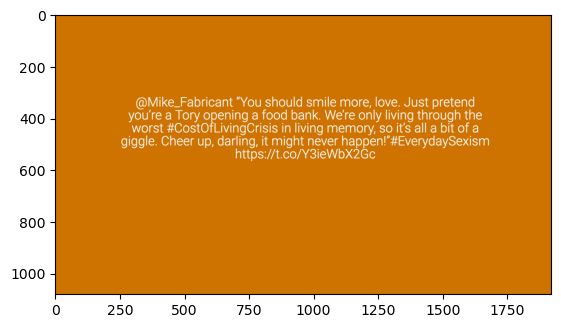

In [ ]:
plt.imshow(img)

In [ ]:
get_prediction(img)

'NO'

In [ ]:
img = cv2.imread('test_YES.jpeg')

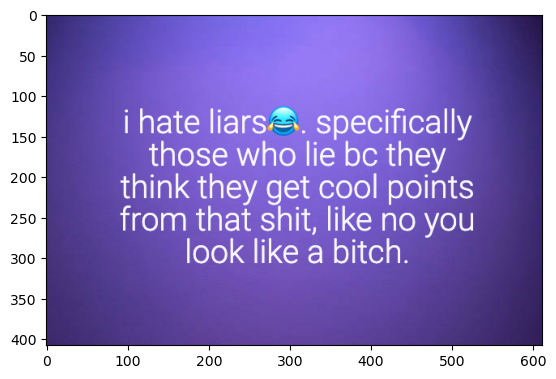

In [ ]:
plt.imshow(img)

In [ ]:
get_prediction(img)

'YES'

##Vader

In [ ]:
import pandas as pd

In [ ]:
tw_data = pd.read_csv('/content/roberta_en_results.csv')

In [ ]:
tw_data = tw_data ['tweet']

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.6 MB/s eta 0:00:00


In [ ]:
# from vaderSentiment.vaderSentiment module.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
sid_obj = SentimentIntensityAnalyzer()

In [ ]:
def get_cat(my_dict):  
  key_list = list(my_dict.keys())
  val_list = list(my_dict.values())

  position = val_list.index(max(val_list))
  return (key_list[position])

In [ ]:
tweets = []
for i in tw_data:
  sentiment_dict = sid_obj.polarity_scores(i)
  del sentiment_dict['compound']
  tweets.append(get_cat(sentiment_dict))

In [ ]:
tweet_categories_temp = []
for i in tw_data:
  sentiment_dict_temp = sid_obj.polarity_scores(i)
  tweet_categories_temp.append(sentiment_dict_temp)

In [ ]:
tweet_categories_temp[0]

{'neg': 0.101, 'neu': 0.597, 'pos': 0.302, 'compound': 0.9085}

In [ ]:
tweet_categories2 = []
for i in tw_data:
  sentiment_dict = sid_obj.polarity_scores(i)
  del sentiment_dict['compound']
  del sentiment_dict['neu']
  tweet_categories2.append(get_cat(sentiment_dict))

In [ ]:
from collections import Counter

In [ ]:
print("Tweet Sentiment")
print(Counter(tweet_categories2))

Tweet Sentiment
Counter({'neg': 1614, 'pos': 1320})


In [ ]:
tweet_df = pd.DataFrame({'Tweets':tw_data,"Sentiment":tweet_categories2})
tweet_df.head(-1)

,Tweets,Sentiment
0,"@Mike_Fabricant “You should smile more, love. ...",pos
1,"@Mike_Fabricant “You should smile more, love. ...",pos
2,"@Mike_Fabricant “You should smile more, love. ...",pos
3,"@Mike_Fabricant “You should smile more, love. ...",pos
4,"@Mike_Fabricant “You should smile more, love. ...",pos
...,...,...
2928,@ElDukemane You look like a whore in ur new pi...,pos
2929,@ElDukemane You look like a whore in ur new pi...,pos
2930,@ElDukemane You look like a whore in ur new pi...,pos
2931,@ElDukemane You look like a whore in ur new pi...,pos


In [ ]:
tweet_df = tweet_df.drop_duplicates(subset=["Tweets"])

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

In [ ]:
y_pred = np.array(tweet_df['Sentiment'].map({'pos':0,'neg':1}))

In [ ]:
y_true = np.array(tw_data[['tweet','t1_lb']].drop_duplicates(subset=['tweet'])['t1_lb'].map({'NO':0,'YES':1}))

In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.55      0.47      0.50       260
           1       0.48      0.57      0.52       229

    accuracy                           0.51       489
   macro avg       0.52      0.52      0.51       489
weighted avg       0.52      0.51      0.51       489



##Label 2

In [ ]:
f = open ('/content/drive/MyDrive/MS/SMM/EXIST2023_training.json', "r")
  
# Reading from file
data = json.loads(f.read())

In [ ]:
df = pd.DataFrame(data).T.drop(['number_annotators','annotators','split'],axis=1)
df.columns = ['id','lang','tweet','sex','age','t1_lb','t2_lb','t3_lb']
df_en = df[df['lang']=='en']
df_es = df[df['lang']=='es']

In [ ]:
training_set_en = df_en.explode(['sex','age','t1_lb','t2_lb','t3_lb']).reset_index(drop=True)
training_set_es = df_es.explode(['sex','age','t1_lb','t2_lb','t3_lb']).reset_index(drop=True)

In [ ]:
f = open ('/content/drive/MyDrive/MS/SMM/EXIST2023_dev.json', "r")
  
# Reading from file
data = json.loads(f.read())

In [ ]:
df_val = pd.DataFrame(data).T.drop(['number_annotators','annotators','split'],axis=1)
df_val.columns = ['id','lang','tweet','sex','age','t1_lb','t2_lb','t3_lb']
df_val_en = df_val[df_val['lang']=='en']
df_val_es = df_val[df_val['lang']=='es']

In [ ]:
val_set_en = df_val_en.explode(['sex','age','t1_lb','t2_lb','t3_lb']).reset_index(drop=True)
val_set_es = df_val_es.explode(['sex','age','t1_lb','t2_lb','t3_lb']).reset_index(drop=True)

In [ ]:
# check if we have cuda installed
if torch.cuda.is_available():
    # to use GPU
    device = torch.device("cuda")
    print('Using GPU')
else:
    device = torch.device("cpu")

Using GPU


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-large')

In [ ]:
features_en = list(training_set_en['tweet'])
targets_en = list(training_set_en['t2_lb'])
val_features_en = list(val_set_en['tweet'])
val_targets_en = list(val_set_en['t2_lb'])

features_es = list(training_set_es['tweet'])
targets_es = list(training_set_es['t2_lb'])
val_features_es = list(val_set_es['tweet'])
val_targets_es = list(val_set_es['t2_lb'])

In [ ]:
MAX_LEN = 128
tokenized_feature_en = tokenizer(
                            # Sentences to encode
                            features_en, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN, 
                            # Return attention mask
                            return_attention_mask = True,   
                   )

MAX_LEN = 128
tokenized_feature_es = tokenizer(
                            # Sentences to encode
                            features_es, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN, 
                            # Return attention mask
                            return_attention_mask = True,   
                   )

In [ ]:

val_tokenized_feature_en = tokenizer(
                            # Sentences to encode
                            val_features_en, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            truncation=True,
                               
                   )


val_tokenized_feature_es = tokenizer(
                            # Sentences to encode
                            val_features_es, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            truncation=True,
                               
                   )

In [ ]:
le = LabelEncoder()
target_num_en = le.fit_transform(targets_en)

le = LabelEncoder()
target_num_es = le.fit_transform(targets_es)

In [ ]:
le = LabelEncoder()
val_target_num_en = le.fit_transform(val_targets_en)

le = LabelEncoder()
val_target_num_es = le.fit_transform(val_targets_es)

In [ ]:
train_inputs_en,train_labels_en,train_masks_en = tokenized_feature_en['input_ids'],target_num_en,tokenized_feature_en['attention_mask']
train_inputs_es,train_labels_es,train_masks_es = tokenized_feature_es['input_ids'],target_num_es,tokenized_feature_es['attention_mask']

In [ ]:
val_inputs_en,val_labels_en,val_masks_en = val_tokenized_feature_en['input_ids'],val_target_num_en,val_tokenized_feature_en['attention_mask']
val_inputs_es,val_labels_es,val_masks_es = val_tokenized_feature_es['input_ids'],val_target_num_es,val_tokenized_feature_es['attention_mask']

In [ ]:
class my_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        input_ids = self.encodings['input_ids'][idx]
        target_ids = torch.tensor(self.labels[idx])
        attention_masks = self.encodings['attention_mask'][idx]
        return {"input_ids": input_ids, "labels": target_ids, "attention_mask":attention_masks}

    def __len__(self):
        return len(self.labels)

In [ ]:
batch_size = 16
# Create the DataLoader for our training set
train_data_en = my_Dataset(tokenized_feature_en,target_num_en)
val_data_en = my_Dataset(val_tokenized_feature_en,val_target_num_en)


train_data_es = my_Dataset(tokenized_feature_es,target_num_es)
val_data_es = my_Dataset(val_tokenized_feature_es,val_target_num_es)

In [ ]:
from transformers import RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
modell2_en = RobertaForSequenceClassification.from_pretrained(
    "roberta-large", 
    # Specify number of classes
    num_labels = len(set(targets_en)), 
    # Whether the model returns attentions weights
    output_attentions = False,
    # Whether the model returns all hidden-states 
    output_hidden_states = False
)

modell2_es = RobertaForSequenceClassification.from_pretrained(
    "roberta-large", 
    # Specify number of classes
    num_labels = len(set(targets_es)), 
    # Whether the model returns attentions weights
    output_attentions = False,
    # Whether the model returns all hidden-states 
    output_hidden_states = False
)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

In [ ]:
optimizer_en = torch.optim.AdamW(modell2_en.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

optimizer_es = torch.optim.AdamW(modell2_es.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [ ]:
modell2_en.cuda()
modell2_es.cuda()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [ ]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.6 MB/s eta 0:00:00


In [ ]:
import evaluate
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)
args = TrainingArguments(
    f"RoBERTa-finetuned-task1",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

In [ ]:
trainerl2_en = Trainer(
    modell2_en,
    args,
    train_dataset=train_data_en,
    eval_dataset=val_data_en,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainerl2_es = Trainer(
    modell2_es,
    args,
    train_dataset=train_data_es,
    eval_dataset=val_data_es,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainerl2_en.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-21-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.965700,1.002386,0.619291
2,0.910000,0.969420,0.608384
3,0.869000,0.952285,0.629516
4,0.816800,0.936740,0.634628
5,0.767100,0.961410,0.631561


<ipython-input-21-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])
<ipython-input-21-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])
<ipython-input-21-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])
<ipython-input-21-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().

TrainOutput(global_step=6115, training_loss=0.8676720245685717, metrics={'train_runtime': 1875.0402, 'train_samples_per_second': 52.159, 'train_steps_per_second': 3.261, 'total_flos': 2.27859527978496e+16, 'train_loss': 0.8676720245685717, 'epoch': 5.0})

In [ ]:
trainerl2_en.save_model('/content/drive/MyDrive/MS/SMM/roberta_modell2_en')

In [ ]:
trainerl2_en.predict(val_data_en)

<ipython-input-21-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])


PredictionOutput(predictions=array([[ 2.118027  ,  0.8663422 ,  0.26887664,  0.08862231, -4.0087757 ],
       [ 2.118027  ,  0.8663422 ,  0.26887664,  0.08862231, -4.0087757 ],
       [ 2.118027  ,  0.8663422 ,  0.26887664,  0.08862231, -4.0087757 ],
       ...,
       [ 0.5609678 ,  2.7313092 ,  0.10002889, -0.9826896 , -2.8349833 ],
       [ 0.5609678 ,  2.7313092 ,  0.10002889, -0.9826896 , -2.8349833 ],
       [ 0.5609678 ,  2.7313092 ,  0.10002889, -0.9826896 , -2.8349833 ]],
      dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 1]), metrics={'test_loss': 0.9367398023605347, 'test_accuracy': 0.634628493524199, 'test_runtime': 10.1037, 'test_samples_per_second': 290.388, 'test_steps_per_second': 18.211})

In [ ]:
# Make predictions on validation data
predictions, _, _ = trainerl2_en.predict(val_data_en)

# Convert predictions to labels
labels = np.argmax(predictions, axis=1)

# Convert labels to desired format
label_map = {0: '-', 1: 'DIRECT', 2: 'JUDGEMENTAL', 3: 'REPORTED'}
labels = [label_map[label] for label in labels]

<ipython-input-21-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])


In [ ]:
val_set_en['Prediction_l2'] = labels

In [ ]:
val_set_en

,id,lang,tweet,sex,age,t1_lb,t2_lb,t3_lb,Prediction_l2
0,400001,en,"@Mike_Fabricant “You should smile more, love. ...",F,18-22,NO,-,[-],-
1,400001,en,"@Mike_Fabricant “You should smile more, love. ...",F,23-45,NO,-,[-],-
2,400001,en,"@Mike_Fabricant “You should smile more, love. ...",F,46+,NO,-,[-],-
3,400001,en,"@Mike_Fabricant “You should smile more, love. ...",M,18-22,NO,-,[-],-
4,400001,en,"@Mike_Fabricant “You should smile more, love. ...",M,23-45,YES,REPORTED,"[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINANC...",-
...,...,...,...,...,...,...,...,...,...
2905,400485,en,@YesReallyAngel “Don’t wear a black bra with a...,F,23-45,YES,DIRECT,"[OBJECTIFICATION, MISOGYNY-NON-SEXUAL-VIOLENCE]",DIRECT
2906,400485,en,@YesReallyAngel “Don’t wear a black bra with a...,F,46+,YES,JUDGEMENTAL,"[STEREOTYPING-DOMINANCE, OBJECTIFICATION, SEXU...",DIRECT
2907,400485,en,@YesReallyAngel “Don’t wear a black bra with a...,M,18-22,YES,DIRECT,"[IDEOLOGICAL-INEQUALITY, OBJECTIFICATION]",DIRECT
2908,400485,en,@YesReallyAngel “Don’t wear a black bra with a...,M,23-45,YES,DIRECT,[OBJECTIFICATION],DIRECT


In [ ]:
val_set_en.to_csv('Roberta_L2_Predictions.csv', index=False)

In [ ]:
trainerl2_es.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-21-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])


Epoch,Training Loss,Validation Loss,Accuracy
1,1.226000,1.267165,0.487250
2,1.220700,1.246477,0.487250
3,1.223900,1.249416,0.487250
4,1.223200,1.243778,0.487250
5,1.222500,1.246464,0.487250


<ipython-input-21-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])
<ipython-input-21-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])
<ipython-input-21-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])
<ipython-input-21-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().

TrainOutput(global_step=6865, training_loss=1.223075298801097, metrics={'train_runtime': 2107.9482, 'train_samples_per_second': 52.089, 'train_steps_per_second': 3.257, 'total_flos': 2.55817752270336e+16, 'train_loss': 1.223075298801097, 'epoch': 5.0})

In [ ]:
trainerl2_es.save_model('/content/drive/MyDrive/MS/SMM/roberta_modell2_es')

In [ ]:
# Make predictions on validation data
predictions, _, _ = trainerl2_es.predict(val_data_es)

# Convert predictions to labels
labels = np.argmax(predictions, axis=1)

# Convert labels to desired format
label_map = {0: '-', 1: 'DIRECT', 2: 'JUDGEMENTAL', 3: 'REPORTED'}
labels = [label_map[label] for label in labels]

<ipython-input-21-53b47ef7adb2>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.labels[idx])


In [ ]:
val_set_es['Prediction_l2'] = labels

In [ ]:
val_set_es.to_csv('RobertaEs_L2_Predictions.csv', index=False)

## Data Visualization

### Neural Network

In [ ]:
nn_data = pd.read_csv('/content/Label 1 NN.csv')

In [ ]:
nn_data.head(25)

,Unnamed: 0,lang,tweet,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,Translated,Predictions
0,0,es,@Fichinescu La comunidad gamer es un antro de ...,F,18-22,NO,-,['-'],@Fichinescu The gaming community has been a de...,NO
1,1,es,@Fichinescu La comunidad gamer es un antro de ...,F,23-45,YES,JUDGEMENTAL,['MISOGYNY-NON-SEXUAL-VIOLENCE'],@Fichinescu The gaming community has been a de...,NO
2,2,es,@Fichinescu La comunidad gamer es un antro de ...,F,46+,YES,JUDGEMENTAL,['MISOGYNY-NON-SEXUAL-VIOLENCE'],@Fichinescu The gaming community has been a de...,NO
3,3,es,@Fichinescu La comunidad gamer es un antro de ...,M,18-22,NO,-,['-'],@Fichinescu The gaming community has been a de...,NO
4,4,es,@Fichinescu La comunidad gamer es un antro de ...,M,23-45,YES,REPORTED,"['SEXUAL-VIOLENCE', 'MISOGYNY-NON-SEXUAL-VIOLE...",@Fichinescu The gaming community has been a de...,NO
5,5,es,@Fichinescu La comunidad gamer es un antro de ...,M,46+,NO,-,['-'],@Fichinescu The gaming community has been a de...,NO
6,6,es,@anacaotica88 @MordorLivin No me acuerdo de lo...,F,18-22,YES,JUDGEMENTAL,"['IDEOLOGICAL-INEQUALITY', 'STEREOTYPING-DOMIN...",@anacaotica88 @MordorLivin I don't remember th...,NO
7,7,es,@anacaotica88 @MordorLivin No me acuerdo de lo...,F,23-45,YES,REPORTED,['MISOGYNY-NON-SEXUAL-VIOLENCE'],@anacaotica88 @MordorLivin I don't remember th...,NO
8,8,es,@anacaotica88 @MordorLivin No me acuerdo de lo...,F,46+,NO,-,['-'],@anacaotica88 @MordorLivin I don't remember th...,NO
9,9,es,@anacaotica88 @MordorLivin No me acuerdo de lo...,M,18-22,YES,JUDGEMENTAL,"['OBJECTIFICATION', 'MISOGYNY-NON-SEXUAL-VIOLE...",@anacaotica88 @MordorLivin I don't remember th...,NO


In [ ]:
new_nn_data = nn_data[['lang', 'Translated', 'Predictions']]

In [ ]:
new_nn_data = new_nn_data.drop_duplicates(subset=["Translated"])

In [ ]:
new_nn_data.head(10)

,lang,Translated,Predictions
0,es,@Fichinescu The gaming community has been a de...,NO
6,es,@anacaotica88 @MordorLivin I don't remember th...,NO
12,es,@cosmicJunkBot I say it every few days and I r...,NO
18,es,"Also, while telling them that, he pointed at h...",YES
24,es,"And all people killed, attacked, harassed by C...",NO
30,es,On this #WorldPressFreedomDay I’m thinking of ...,NO
36,es,@DavidGR18 @pppbernat @abc_es @agarzon @IreneM...,YES
42,es,@DavidArranzVox @AnabelAlonso_of Uyyy what doe...,YES
48,es,With 25 Lions🦁 and 500 more in the stands🗣!!#E...,NO
54,es,@kokreto84 @Play87834898 @venusoncrack I would...,YES


In [ ]:
counts = new_nn_data['Predictions'].value_counts()
# print the counts
print(counts)

YES    520
NO     518
Name: Predictions, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

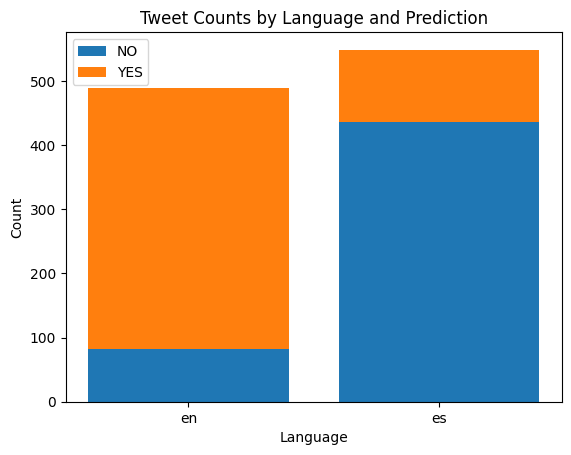

In [ ]:
# group the data by language and prediction, and count the occurrences
counts = new_nn_data.groupby(['lang', 'Predictions'])['Predictions'].count()

# extract the counts for NO and YES predictions
no_counts = counts.loc[:, 'NO']
yes_counts = counts.loc[:, 'YES']

# create a bar chart of tweet counts by language and prediction
fig, ax = plt.subplots()
ax.bar(no_counts.index, no_counts.values, label='NO')
ax.bar(yes_counts.index, yes_counts.values, bottom=no_counts.values, label='YES')
ax.set_title('Tweet Counts by Language and Prediction')
ax.set_xlabel('Language')
ax.set_ylabel('Count')
ax.legend()
plt.show()

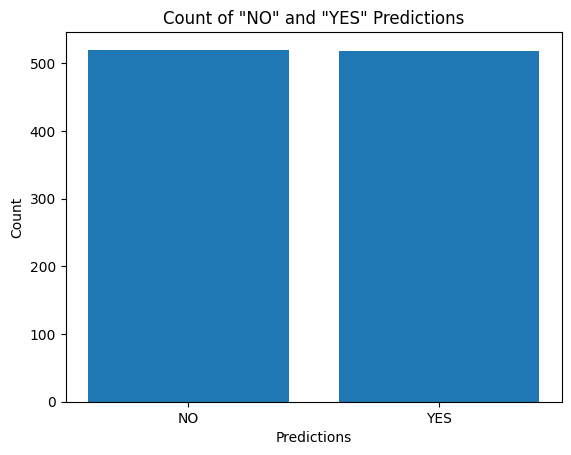

In [ ]:
counts = new_nn_data['Predictions'].value_counts()

# create a bar chart of the counts
plt.bar(['NO', 'YES'], counts.values)
plt.title('Count of "NO" and "YES" Predictions')
plt.xlabel('Predictions')
plt.ylabel('Count')
plt.show()

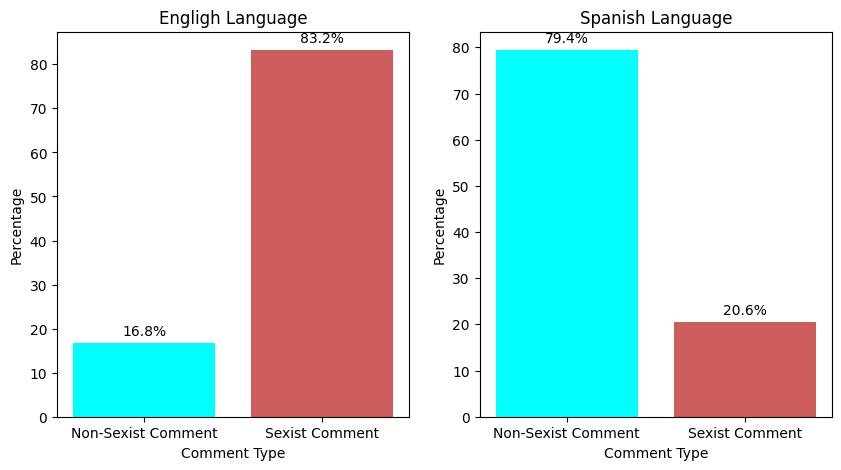

In [ ]:
# create a subset of the data for each language
en_data = new_nn_data[new_nn_data['lang'] == 'en']
es_data = new_nn_data[new_nn_data['lang'] == 'es']

# group the data by prediction, and count the values
en_counts = en_data['Predictions'].value_counts()
es_counts = es_data['Predictions'].value_counts()

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# create a dictionary of colors for each prediction
colors = {'NO': 'cyan', 'YES': 'indianred'}

# create a bar chart of the counts for lang 'en', with colored bars
en_total = en_counts.sum()
en_percentages = [100*en_counts[pred]/en_total for pred in ['NO', 'YES']]
en_bars = ax1.bar(['Non-Sexist Comment', 'Sexist Comment'], en_percentages, color=[colors[pred] for pred in ['NO', 'YES']])
ax1.set_title('Engligh Language')
ax1.set_xlabel('Comment Type')
ax1.set_ylabel('Percentage')
for i, bar in enumerate(en_bars):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, f'{en_percentages[i]:.1f}%', ha='center', va='bottom')

# create a bar chart of the counts for lang 'es', with colored bars
es_total = es_counts.sum()
es_percentages = [100*es_counts[pred]/es_total for pred in ['NO', 'YES']]
es_bars = ax2.bar(['Non-Sexist Comment', 'Sexist Comment'], es_percentages, color=[colors[pred] for pred in ['NO', 'YES']])
ax2.set_title('Spanish Language')
ax2.set_xlabel('Comment Type')
ax2.set_ylabel('Percentage')
for i, bar in enumerate(es_bars):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, f'{es_percentages[i]:.1f}%', ha='center', va='bottom')

# show the figure
plt.show()


### Roberta Model

In [ ]:
roberta_en_data = pd.read_csv('/content/roberta_en_results.csv')

In [ ]:
roberta_en_data

,Unnamed: 0,id,lang,tweet,sex,age,t1_lb,t2_lb,t3_lb,Predictions
0,0,400001,en,"@Mike_Fabricant “You should smile more, love. ...",F,18-22,NO,-,['-'],NO
1,1,400001,en,"@Mike_Fabricant “You should smile more, love. ...",F,23-45,NO,-,['-'],NO
2,2,400001,en,"@Mike_Fabricant “You should smile more, love. ...",F,46+,NO,-,['-'],NO
3,3,400001,en,"@Mike_Fabricant “You should smile more, love. ...",M,18-22,NO,-,['-'],NO
4,4,400001,en,"@Mike_Fabricant “You should smile more, love. ...",M,23-45,YES,REPORTED,"['IDEOLOGICAL-INEQUALITY', 'STEREOTYPING-DOMIN...",NO
...,...,...,...,...,...,...,...,...,...,...
2929,2929,400489,en,@ElDukemane You look like a whore in ur new pi...,F,23-45,YES,DIRECT,"['IDEOLOGICAL-INEQUALITY', 'OBJECTIFICATION', ...",YES
2930,2930,400489,en,@ElDukemane You look like a whore in ur new pi...,F,46+,YES,JUDGEMENTAL,['IDEOLOGICAL-INEQUALITY'],YES
2931,2931,400489,en,@ElDukemane You look like a whore in ur new pi...,M,18-22,YES,DIRECT,['OBJECTIFICATION'],YES
2932,2932,400489,en,@ElDukemane You look like a whore in ur new pi...,M,23-45,YES,DIRECT,['SEXUAL-VIOLENCE'],YES


In [ ]:
new_roberta_en_data = roberta_en_data[['lang', 'tweet', 'Predictions']]

In [ ]:
new_roberta_en_data

,lang,tweet,Predictions
0,en,"@Mike_Fabricant “You should smile more, love. ...",NO
1,en,"@Mike_Fabricant “You should smile more, love. ...",NO
2,en,"@Mike_Fabricant “You should smile more, love. ...",NO
3,en,"@Mike_Fabricant “You should smile more, love. ...",NO
4,en,"@Mike_Fabricant “You should smile more, love. ...",NO
...,...,...,...
2929,en,@ElDukemane You look like a whore in ur new pi...,YES
2930,en,@ElDukemane You look like a whore in ur new pi...,YES
2931,en,@ElDukemane You look like a whore in ur new pi...,YES
2932,en,@ElDukemane You look like a whore in ur new pi...,YES


In [ ]:
roberta_es_data = pd.read_csv('/content/roberta_es_results.csv')

In [ ]:
new_roberta_es_data = roberta_es_data[['lang', 'tweet', 'Predictions']]

In [ ]:
new_roberta_es_data

,lang,tweet,Predictions
0,es,@Fichinescu La comunidad gamer es un antro de ...,NO
1,es,@Fichinescu La comunidad gamer es un antro de ...,NO
2,es,@Fichinescu La comunidad gamer es un antro de ...,NO
3,es,@Fichinescu La comunidad gamer es un antro de ...,NO
4,es,@Fichinescu La comunidad gamer es un antro de ...,NO
...,...,...,...
3289,es,@LillyTellez Le pagamos bien a la senadora cha...,YES
3290,es,@LillyTellez Le pagamos bien a la senadora cha...,YES
3291,es,@LillyTellez Le pagamos bien a la senadora cha...,YES
3292,es,@LillyTellez Le pagamos bien a la senadora cha...,YES


In [ ]:
new_roberta_es_data = new_roberta_es_data.drop_duplicates(subset=["tweet"])

In [ ]:
new_roberta_data = pd.concat([new_roberta_en_data, new_roberta_es_data], ignore_index=True)

In [ ]:
new_roberta_data

,lang,tweet,Predictions
0,en,"@Mike_Fabricant “You should smile more, love. ...",NO
1,en,"@Mike_Fabricant “You should smile more, love. ...",NO
2,en,"@Mike_Fabricant “You should smile more, love. ...",NO
3,en,"@Mike_Fabricant “You should smile more, love. ...",NO
4,en,"@Mike_Fabricant “You should smile more, love. ...",NO
...,...,...,...
3478,es,#ChiringuitoHaaland Dice la zorra de estar ver...,YES
3479,es,soy una zorra por el kayn el mayor jodido smas...,YES
3480,es,"Poniéndoseme en contra solo por las sombras, h...",YES
3481,es,@srthouston Me lo estoy perdiendo y no estoy n...,YES


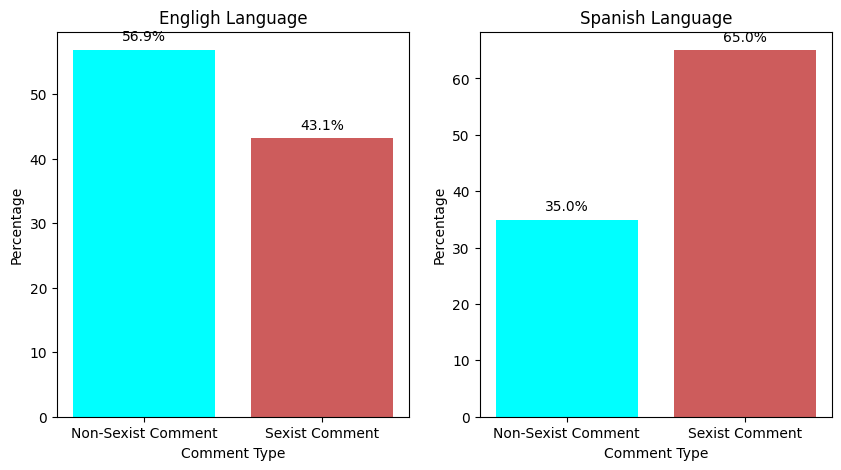

In [ ]:
# create a subset of the data for each language
en_data = new_roberta_data[new_roberta_data['lang'] == 'en']
es_data = new_roberta_data[new_roberta_data['lang'] == 'es']

# group the data by prediction, and count the values
en_counts = en_data['Predictions'].value_counts()
es_counts = es_data['Predictions'].value_counts()

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# create a dictionary of colors for each prediction
colors = {'NO': 'cyan', 'YES': 'indianred'}

# create a bar chart of the counts for lang 'en', with colored bars
en_total = en_counts.sum()
en_percentages = [100*en_counts[pred]/en_total for pred in ['NO', 'YES']]
en_bars = ax1.bar(['Non-Sexist Comment', 'Sexist Comment'], en_percentages, color=[colors[pred] for pred in ['NO', 'YES']])
ax1.set_title('Engligh Language')
ax1.set_xlabel('Comment Type')
ax1.set_ylabel('Percentage')
for i, bar in enumerate(en_bars):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, f'{en_percentages[i]:.1f}%', ha='center', va='bottom')

# create a bar chart of the counts for lang 'es', with colored bars
es_total = es_counts.sum()
es_percentages = [100*es_counts[pred]/es_total for pred in ['NO', 'YES']]
es_bars = ax2.bar(['Non-Sexist Comment', 'Sexist Comment'], es_percentages, color=[colors[pred] for pred in ['NO', 'YES']])
ax2.set_title('Spanish Language')
ax2.set_xlabel('Comment Type')
ax2.set_ylabel('Percentage')
for i, bar in enumerate(es_bars):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, f'{es_percentages[i]:.1f}%', ha='center', va='bottom')

# show the figure
plt.show()


In [ ]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


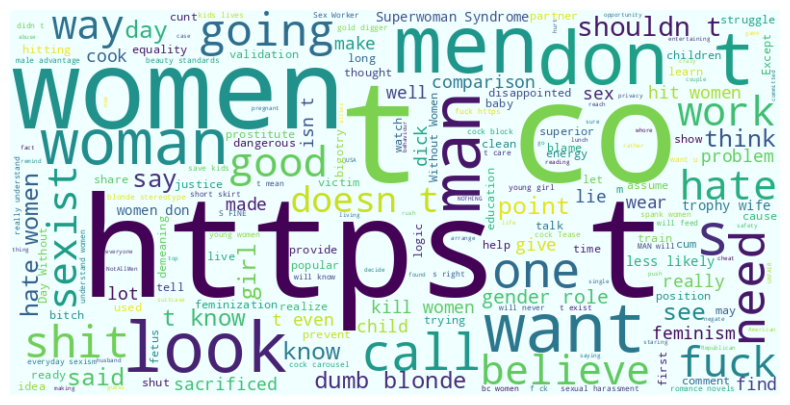

In [ ]:
from wordcloud import WordCloud

# combine all tweets into a single string
text = ' '.join(new_roberta_en_data[new_roberta_en_data['Predictions'] == 'YES']['tweet'])

# generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='azure').generate(text)

# display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

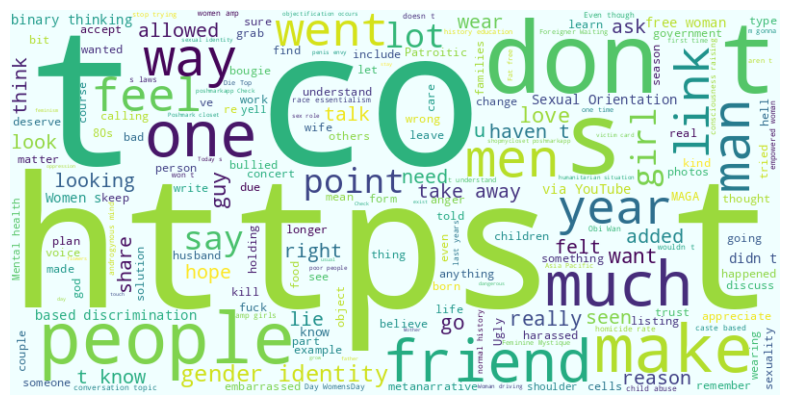

In [ ]:
from wordcloud import WordCloud

# combine all tweets into a single string
text = ' '.join(new_roberta_en_data[new_roberta_en_data['Predictions'] == 'NO']['tweet'])

# generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='azure').generate(text)

# display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
robertal2_en_data = pd.read_csv('/content/RobertaEn_L2_Predictions.csv')

In [ ]:
robertal2_en_data

,id,lang,tweet,sex,age,t1_lb,t2_lb,t3_lb,Prediction_l2
0,400001,en,"@Mike_Fabricant “You should smile more, love. ...",F,18-22,NO,-,['-'],-
1,400001,en,"@Mike_Fabricant “You should smile more, love. ...",F,23-45,NO,-,['-'],-
2,400001,en,"@Mike_Fabricant “You should smile more, love. ...",F,46+,NO,-,['-'],-
3,400001,en,"@Mike_Fabricant “You should smile more, love. ...",M,18-22,NO,-,['-'],-
4,400001,en,"@Mike_Fabricant “You should smile more, love. ...",M,23-45,YES,REPORTED,"['IDEOLOGICAL-INEQUALITY', 'STEREOTYPING-DOMIN...",-
...,...,...,...,...,...,...,...,...,...
2929,400489,en,@ElDukemane You look like a whore in ur new pi...,F,23-45,YES,DIRECT,"['IDEOLOGICAL-INEQUALITY', 'OBJECTIFICATION', ...",DIRECT
2930,400489,en,@ElDukemane You look like a whore in ur new pi...,F,46+,YES,JUDGEMENTAL,['IDEOLOGICAL-INEQUALITY'],DIRECT
2931,400489,en,@ElDukemane You look like a whore in ur new pi...,M,18-22,YES,DIRECT,['OBJECTIFICATION'],DIRECT
2932,400489,en,@ElDukemane You look like a whore in ur new pi...,M,23-45,YES,DIRECT,['SEXUAL-VIOLENCE'],DIRECT


In [ ]:
new_robertal2_en_data = robertal2_en_data[['lang', 'tweet', 'Prediction_l2']]

In [ ]:
new_robertal2_en_data = new_robertal2_en_data.drop_duplicates(subset=["tweet"])

In [ ]:
# create boolean mask for rows where Prediction_l2 is not '-'
mask = new_robertal2_en_data['Prediction_l2'] != '-'

# filter the dataframe to only include rows where the mask is True
new_robertal2_en_data_filtered = new_robertal2_en_data[mask]


In [ ]:
print(new_robertal2_en_data_filtered.head(10))

    lang                                              tweet Prediction_l2
6     en  @BBCWomansHour @LabWomenDec @EverydaySexism Sh...   JUDGEMENTAL
12    en  #everydaysexism Some man moving my suitcase in...      REPORTED
60    en  @esjayXX @EcuadorianMum @monsalore They so rem...      REPORTED
72    en  One of the depressing things about #NotAllMen ...   JUDGEMENTAL
102   en  Shit is crazy. If u want an open relationship,...   JUDGEMENTAL
114   en  @GoldenSteeler06 @Matthew07219782 @PocketMaxim...      REPORTED
180   en  We need to call for A Day Without Women. Where...        DIRECT
186   en  @sage_ranae This world wouldn’t last a day wit...        DIRECT
192   en  What a day without women would really do to th...        DIRECT
252   en  men for centuries: women are dumb. *dumb blond...        DIRECT


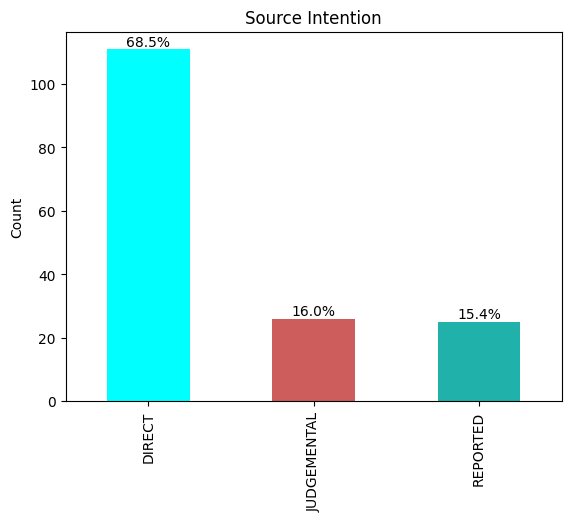

In [ ]:
# get the count of each value in the Prediction_l2 column
counts = new_robertal2_en_data_filtered['Prediction_l2'].value_counts()

# calculate the percentage of each value
percentages = counts / counts.sum() * 100

# define some colors
colors = {'DIRECT': 'cyan', 'JUDGEMENTAL': 'indianred', 'REPORTED': 'lightseagreen'}

# plot the counts as a bar plot
ax = counts.plot.bar(color=[colors[x] for x in counts.index])
ax.set_title('Source Intention')
ax.set_ylabel('Count')

# add the percentage values as annotations to the bars
for i, count in enumerate(counts):
    ax.text(i, count + 1, f"{percentages[i]:.1f}%", ha='center')

plt.show()
